[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PTB-MR/mrpro/blob/main/examples/notebooks/cartesian_reconstruction.ipynb) [![Download notebook](https://img.shields.io/badge/Download-notebook-blue?logo=jupyter)](path:cartesian_reconstruction.ipynb)

In [1]:
import importlib

if not importlib.util.find_spec('mrpro'):
    %pip install mrpro[notebook]

# Basics of MRpro and Cartesian Reconstructions
Here, we are going to have a look at a few basics of MRpro and reconstruct data acquired with a Cartesian sampling
pattern.

## Overview

In this notebook, we are going to explore the MRpro KData object and the included header parameters. We will then use
a FFT-operator in order to reconstruct data acquired with a Cartesian sampling scheme. We will also reconstruct data
acquired on a Cartesian grid but with partial echo and partial Fourier acceleration. Finally, we will reconstruct a
Cartesian scan with regular undersampling using iterative SENSE.

## Import MRpro and download data

In [2]:
# Get the raw data from zenodo
import tempfile
from pathlib import Path

import zenodo_get

data_folder = Path(tempfile.mkdtemp())
dataset = '14173489'
zenodo_get.zenodo_get([dataset, '-r', 5, '-o', data_folder])  # r: retries

Title: 2D Cartesian MR raw data
Keywords: MR raw data
Publication date: 2024-11-16
DOI: 10.5281/zenodo.14173489
Total size: 140.9 MB

Link: https://zenodo.org/records/14173489/files/cart_t1.mrd   size: 50.7 MB



Checksum is correct. (45a3698b0c3b14de224172b7be46ac34)

Link: https://zenodo.org/records/14173489/files/cart_t1_msense_integrated.mrd   size: 43.9 MB



Checksum is correct. (4678ea99f7f9bcdd48127abef044dfe6)

Link: https://zenodo.org/records/14173489/files/cart_t1_partial_echo_partial_fourier.mrd   size: 46.2 MB



Checksum is correct. (6c069c1e804e25b3942bf10f6abde2db)
All files have been downloaded.


In [3]:
# List the downloaded files
for f in data_folder.iterdir():
    print(f.name)

cart_t1.mrd
cart_t1_partial_echo_partial_fourier.mrd
cart_t1_msense_integrated.mrd
md5sums.txt


We have three different scans obtained from the same object with the same FOV and resolution:

- cart_t1.mrd is a fully sampled Cartesian acquisition

- cart_t1_msense_integrated.mrd is accelerated using regular undersampling and self-calibrated SENSE

- cart_t1_partial_echo_partial_fourier.mrd is accelerated using partial echo and partial Fourier

## Read in raw data and explore header

To read in an ISMRMRD raw data file (*.mrd), we can simply pass on the file name to a `KData` object.
Additionally, we need to provide information about the trajectory. In MRpro, this is done using trajectory
calculators. These are functions that calculate the trajectory based on the acquisition information and additional
parameters provided to the calculators (e.g. the angular step for a radial acquisition).

In this case, we have a Cartesian acquisition. This means that we only need to provide a Cartesian trajectory
calculator (called `KTrajectoryCartesian` in MRpro) without any further parameters.

In [4]:
from mrpro.data import KData
from mrpro.data.traj_calculators import KTrajectoryCartesian

kdata = KData.from_file(data_folder / 'cart_t1.mrd', KTrajectoryCartesian())

Now we can explore this data object.

In [5]:
# Start with simply calling print(kdata), whichs gives us a nice overview of the KData object.
print(kdata)

KData with shape [1, 16, 1, 256, 512] and dtype torch.complex64
Device: cpu
KTrajectory with shape: kz=[1, 1, 1, 1], ky=[  1,   1, 256,   1], kx=[  1,   1,   1, 512]
FOV [m]: z=0.004, y=0.256, x=0.512
TE [s]: [0.0029]
TI [s]: [0.3000]
Flip angle [rad]: None
Encoding matrix: z=1, y=256, x=512 
Recon matrix: z=1, y=256, x=256 



In [6]:
# We can also have a look at more specific header information like the 1H Lamor frequency
print(kdata.header.lamor_frequency_proton)

123252558


## Reconstruction of fully sampled acquisition

For the reconstruction of a fully sampled Cartesian acquisition, we can use a simple Fast Fourier Transform (FFT).

Let's create an FFT-operator (called `FastFourierOp` in MRpro) and apply it to our `KData` object. Please note that
all MRpro operators currently only work on PyTorch tensors and not on the MRpro objects directly. Therefore, we have
to call the operator on kdata.data. One other important feature of MRpro operators is that they always return a
tuple of PyTorch tensors, even if the output is only a single tensor. This is why we use the `(img,)` syntax below.

In [7]:
from mrpro.operators import FastFourierOp

fft_op = FastFourierOp(dim=(-2, -1))
(img,) = fft_op.adjoint(kdata.data)

Let's have a look at the shape of the obtained tensor.

In [8]:
print(img.shape)

torch.Size([1, 16, 1, 256, 512])


We can see that the second dimension, which is the coil dimension, is 16. This means we still have a coil resolved
dataset (i.e. one image for each coil element). We can use a simply root-sum-of-squares approach to combine them into
one. Later, we will do something a bit more sophisticated. We can also see that the x-dimension is 512. This is
because in MRI we commonly oversample the readout direction by a factor 2 leading to a FOV twice as large as we
actually need. We can either remove this oversampling along the readout direction or we can simply tell the
`FastFourierOp` to crop the image by providing the correct output matrix size (recon_matrix).

In [9]:
# Create FFT-operator with correct output matrix size
fft_op = FastFourierOp(
    dim=(-2, -1),
    recon_matrix=kdata.header.recon_matrix,
    encoding_matrix=kdata.header.encoding_matrix,
)

(img,) = fft_op.adjoint(kdata.data)
print(img.shape)

torch.Size([1, 16, 1, 256, 256])


Now, we have an image which is 256 x 256 voxel as we would expect. Let's combine the data from the different receiver
coils using root-sum-of-squares and then display the image. Note that we usually index from behind in MRpro
(i.e. -1 for the last, -4 for the fourth last (coil) dimension) to allow for more than one 'other' dimension.

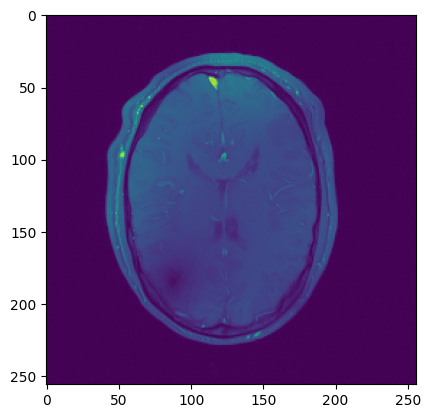

In [10]:
import matplotlib.pyplot as plt
import torch

# Combine data from different coils
img_fully_sampled = torch.sqrt(torch.sum(img**2, dim=-4)).abs().squeeze()

# plot the image
plt.imshow(img_fully_sampled)

Great! That was very easy! Let's try to reconstruct the next dataset.

## Reconstruction of acquisition with partial echo and partial Fourier

In [11]:
# Read in the data
kdata_pe_pf = KData.from_file(data_folder / 'cart_t1_partial_echo_partial_fourier.mrd', KTrajectoryCartesian())

# Create FFT-operator with correct output matrix size
fft_op = FastFourierOp(
    dim=(-2, -1),
    recon_matrix=kdata.header.recon_matrix,
    encoding_matrix=kdata.header.encoding_matrix,
)

# Reconstruct coil resolved image(s)
(img_pe_pf,) = fft_op.adjoint(kdata_pe_pf.data)

# Combine data from different coils using root-sum-of-squares
img_pe_pf = torch.sqrt(torch.sum(img_pe_pf**2, dim=-4)).abs().squeeze()

# Plot both images
fig, ax = plt.subplots(1, 2, squeeze=False)
ax[0, 0].imshow(img_fully_sampled)
ax[0, 1].imshow(img_pe_pf)

Well, we got an image, but when we compare it to the previous result, it seems like the head has shrunk.
Since that's extremely unlikely, there's probably a mistake in our reconstruction.

Let's step back and check out the trajectories for both scans.

In [12]:
print(kdata.traj)

KTrajectory with shape: kz=[1, 1, 1, 1], ky=[  1,   1, 256,   1], kx=[  1,   1,   1, 512]


We see that the trajectory has kz, ky, and kx components. Kx and ky only vary along one dimension.
This is because MRpro saves the trajectory in the most efficient way.
To get the full trajectory as a tensor, we can just call as_tensor().

In [13]:
# Plot the fully sampled trajectory (in blue)
plt.plot(kdata.traj.as_tensor()[2, 0, 0, :, :].flatten(), kdata.traj.as_tensor()[1, 0, 0, :, :].flatten(), 'ob')

# Plot the partial echo and partial Fourier trajectory (in red)
plt.plot(
    kdata_pe_pf.traj.as_tensor()[2, 0, 0, :, :].flatten(), kdata_pe_pf.traj.as_tensor()[1, 0, 0, :, :].flatten(), '+r'
)

We see that for the fully sampled acquisition, the k-space is covered symmetrically from -256 to 255 along the
readout direction and from -128 to 127 along the phase encoding direction. For the acquisition with partial Fourier
and partial echo acceleration, this is of course not the case and the k-space is asymmetrical.

Our FFT-operator does not know about this and simply assumes that the acquisition is symmetric and any difference
between encoding and recon matrix needs to be zero-padded symmetrically.

To take the asymmetric acquisition into account and sort the data correctly into a matrix where we can apply the
FFT-operator to, we have got the `CartesianSamplingOp` in MRpro. This operator calculates a sorting index based on the
k-space trajectory and the dimensions of the encoding k-space.

Let's try it out!

In [14]:
from mrpro.operators import CartesianSamplingOp

cart_sampling_op = CartesianSamplingOp(encoding_matrix=kdata_pe_pf.header.encoding_matrix, traj=kdata_pe_pf.traj)

Now, we first apply the CartesianSamplingOp and then call the FFT-operator.

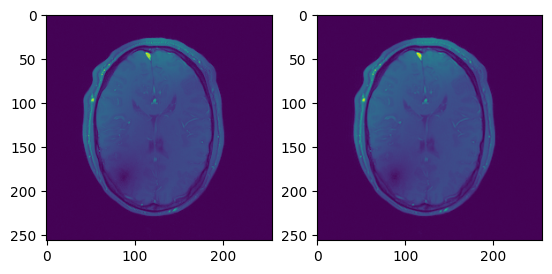

In [15]:
(img_pe_pf,) = fft_op.adjoint(cart_sampling_op.adjoint(kdata_pe_pf.data)[0])
img_pe_pf = torch.sqrt(torch.sum(img_pe_pf**2, dim=-4)).abs().squeeze()

fig, ax = plt.subplots(1, 2, squeeze=False)
ax[0, 0].imshow(img_fully_sampled)
ax[0, 1].imshow(img_pe_pf)

Voila! We've got the same brains, and they're the same size!

But wait a second—something still looks a bit off. In the bottom left corner, it seems like there's a "hole"
in the brain. That definitely shouldn't be there.

The issue is that we combined the data from the different coils using a root-sum-of-squares approach.
While it's simple, it's not the ideal method. Typically, coil sensitivity maps are calculated to combine the data
from different coils. In MRpro, you can do this by calculating coil sensitivity data and then creating a
`SensitivityOp` to combine the data after image reconstruction.

We have different options for calculating coil sensitivity maps from the image data of the various coils.
Here, we're going to use the Walsh method.

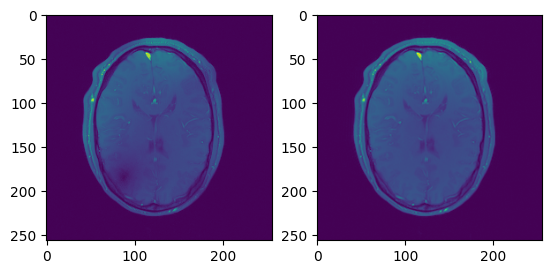

In [16]:
from mrpro.algorithms.csm import walsh
from mrpro.operators import SensitivityOp

# Calculate coil sensitivity maps
(img_pe_pf,) = fft_op.adjoint(cart_sampling_op.adjoint(kdata_pe_pf.data)[0])

# This algorithms is designed to calculate coil sensitivity maps for each other dimension.
csm_data = walsh(img_pe_pf[0, ...], smoothing_width=5)[None, ...]

# Create SensitivityOp
csm_op = SensitivityOp(csm_data)

# Reconstruct coil-combined image
(img_pe_pf,) = csm_op.adjoint(fft_op.adjoint(cart_sampling_op.adjoint(kdata_pe_pf.data)[0])[0])
img_pe_pf = img_pe_pf.abs().squeeze()

fig, ax = plt.subplots(1, 2, squeeze=False)
ax[0, 0].imshow(img_fully_sampled)
ax[0, 1].imshow(img_pe_pf.squeeze())

Tada! The "hole" is gone, and the image looks much better.

When we reconstructed the image, we called the adjoint method of several different operators one after the other. That
was a bit cumbersome. To make our life easier, MRpro allows to combine the operators first and then call the adjoint
of the composite operator. We have to keep in mind that we have to put them in the order of the forward method of the
operators. By calling the adjoint, the order will be automatically reversed.

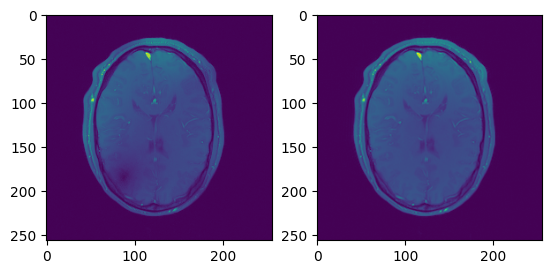

In [17]:
# Create composite operator
acq_op = cart_sampling_op @ fft_op @ csm_op
(img_pe_pf,) = acq_op.adjoint(kdata_pe_pf.data)
img_pe_pf = img_pe_pf.abs().squeeze()

fig, ax = plt.subplots(1, 2, squeeze=False)
ax[0, 0].imshow(img_fully_sampled)
ax[0, 1].imshow(img_pe_pf)

Although we now have got a nice looking image, it was still a bit cumbersome to create it. We had to define several
different operators and chain them together. Wouldn't it be nice if this could be done automatically?

That is why we also included some top-level reconstruction algorithms in MRpro. For this whole steps from above,
we can simply call a `DirectReconstruction`. A `DirectReconstruction` object can be created from only the information
in the `KData` object.

In contrast to operators, top-level reconstruction algorithms operate on the data objects of MRpro, i.e. the input is
a `KData` object and the output is an image data (called `IData` in MRpro) object. To get the tensor content of the
`IData` object, we can call its `rss` method.

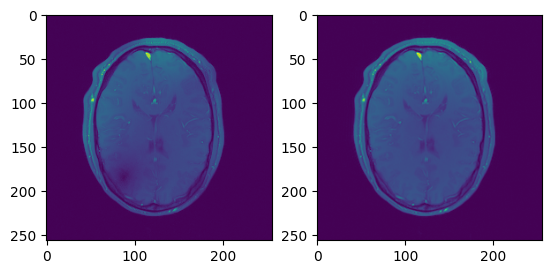

In [18]:
from mrpro.algorithms.reconstruction import DirectReconstruction

# Create DirectReconstruction object from KData object
direct_recon_pe_pf = DirectReconstruction(kdata_pe_pf)

# Reconstruct image by calling the DirectReconstruction object
idat_pe_pf = direct_recon_pe_pf(kdata_pe_pf)

fig, ax = plt.subplots(1, 2, squeeze=False)
ax[0, 0].imshow(img_fully_sampled)
ax[0, 1].imshow(idat_pe_pf.rss().squeeze())

This is much simpler — everything happens in the background, so we don't have to worry about it.
Let's try it on the undersampled dataset now.

## Reconstruction of undersampled data

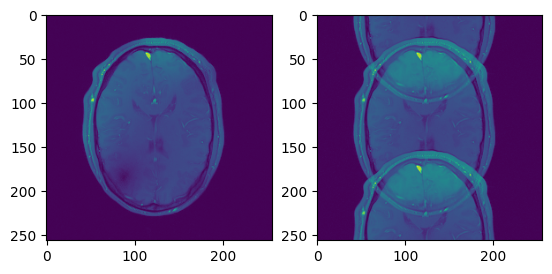

In [19]:
kdata_us = KData.from_file(data_folder / 'cart_t1_msense_integrated.mrd', KTrajectoryCartesian())
direct_recon_us = DirectReconstruction(kdata_us)
idat_us = direct_recon_us(kdata_us)

fig, ax = plt.subplots(1, 2, squeeze=False)
ax[0, 0].imshow(img_fully_sampled)
ax[0, 1].imshow(idat_us.rss().squeeze())

As expected, we can see undersampling artifacts in the image. In order to get rid of them, we can use an iterative
SENSE algorithm. As you might have guessed, this is also included in MRpro.

Similarly to the `DirectReconstruction`, we can create an `IterativeSENSEReconstruction` and apply it to the
undersampled data.

One important thing to keep in mind is that this only works if the coil maps that we use do not have any
undersampling artifacts. Commonly, we would get them from a fully sampled self-calibration reference lines in the
center of k-space or a separate coil sensitivity scan.

As a first step, we are going to assume that we have got a nice fully sampled reference scan like our partial echo and
partial Fourier acquisition. We can get the `CsmData`, which is needed for the `IterativeSENSEReconstruction`, from
the previous reconstruction.

In [20]:
from mrpro.algorithms.reconstruction import IterativeSENSEReconstruction

it_sense_recon = IterativeSENSEReconstruction(kdata=kdata_us, csm=direct_recon_pe_pf.csm)
idat_us = it_sense_recon(kdata_us)

fig, ax = plt.subplots(1, 2, squeeze=False)
ax[0, 0].imshow(img_fully_sampled)
ax[0, 1].imshow(idat_us.rss().squeeze())

That worked well, but in practice, we don't want to acquire a fully sampled version of our scan just to
reconstruct it. A more efficient approach is to get a few self-calibration lines in the center of k-space
to create a low-resolution, fully sampled image.

In our scan, these lines are part of the dataset, but they aren't used for image reconstruction since
they're only meant for calibration (i.e., coil sensitivity map calculation). Because they're not labeled
for imaging, MRpro ignores them by default when reading the data. However, we can set a flag when calling
`from_file` to read in just those lines for reconstructing the coil sensitivity maps.

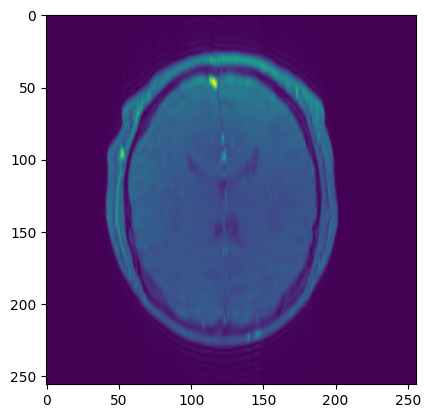

In [21]:
from mrpro.data.acq_filters import is_coil_calibration_acquisition

kdata_calib_lines = KData.from_file(
    data_folder / 'cart_t1_msense_integrated.mrd',
    KTrajectoryCartesian(),
    acquisition_filter_criterion=lambda acq: is_coil_calibration_acquisition(acq),
)

direct_recon_calib_lines = DirectReconstruction(kdata_calib_lines)
im_calib_lines = direct_recon_calib_lines(kdata_calib_lines)

plt.imshow(im_calib_lines.rss().squeeze())

Although this only yields a low-resolution image, it is good enough to calculate coil sensitivity maps.

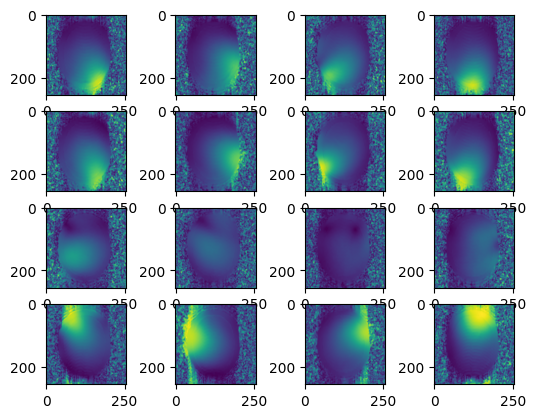

In [22]:
# Visualize coil sensitivity maps of all 16 coils
assert direct_recon_calib_lines.csm is not None  # needed for type checking
fig, ax = plt.subplots(4, 4, squeeze=False)
for idx, cax in enumerate(ax.flatten()):
    cax.imshow(direct_recon_calib_lines.csm.data[0, idx, 0, ...].abs())

Now, we can use these coil sensitivity maps to reconstruct our SENSE scan.

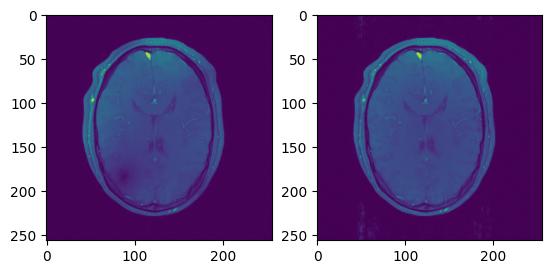

In [23]:
it_sense_recon = IterativeSENSEReconstruction(kdata_us, csm=direct_recon_calib_lines.csm)
idat_us = it_sense_recon(kdata_us)

fig, ax = plt.subplots(1, 2, squeeze=False)
ax[0, 0].imshow(img_fully_sampled)
ax[0, 1].imshow(idat_us.rss().squeeze())

The final image is a little worse (nothing beats fully sampled high-resolution scans for coil map
calculation), but we've managed to get rid of the undersampling artifacts inside the brain. If you want to
further improve the coil sensitivity map quality, try:
- using different methods to calculate them, e.g. `mrpro.algorithms.csm.inati`
- playing around with the parameters of these methods
- applying a smoothing filter on the images (or ideally directly in k-space) used to calculate the coil
  sensitivity maps